In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, Hz, kelvin
import h5py

from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_Simba
from synthesizer.sed import Sed
from synthesizer.filters import Filter, FilterCollection
from synthesizer.sed import combine_list_of_seds
from synthesizer.emission_models import (
    IncidentEmission,
)

from synthesizer.conversions import lnu_to_absolute_mag, fnu_to_apparent_mag, fnu_to_lnu

In [2]:
# get grid for all galaxies
# gives grid of metalicity and age which is used to map on our camels galaxies
grid_name = "bc03_chabrier03-0.1,100.hdf5"
#grid_name = "bc03-2016-Miles_chabrier-0.1,100.hdf5" # try old grid, LF looks weird?!
grid_dir = "/home/jovyan/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

In [3]:
# get gals
CV_X = 'CV_0'
dir_ = '/home/jovyan/Data/Sims/SIMBA/CV/' + CV_X
gals_074 = load_CAMELS_Simba(
    dir_,
    snap_name='snapshot_074.hdf5', 
    group_name='groups_074.hdf5',
)



/srv/conda/envs/notebook/lib/python3.9/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


In [4]:

print('Number of Galaxies in snap_074', len(gals_074))

cat_074 = dir_+'/groups_074.hdf5'
# open file
f = h5py.File(cat_074, 'r')

# read different attributes of the header
boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_074 = f['Header'].attrs[u'Redshift']
print('BoxSize: ', boxSize_074)
print('redshift: ', redshift_074)

Number of Galaxies in snap_074 21473
BoxSize:  25.0
redshift:  0.4658364469731915


In [5]:
# Filter galaxies to only include those with 100 or more star particles
## NEED TO ADD FILTER TO GET RID OF ANY GALAXIES WITH LESS THAN 100 star Particles!! This is the resolution limit!!
# Chris: when you load your galaxies in could you do a filter for those with at least 100 star particles? that's the resolution limit
gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]  # this shouldnt be here?! donesnt make sense
# Filter galaxies to only include those with 100 or more star particles
gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
print(len(gals_074))
gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]


468


In [6]:
incident = IncidentEmission(grid)
little_h =  0.6711

spec_list = []
# Lets work with z=0 so gals_025
for i in gals_074:
    gal = i
    # get_spectra_incident An Sed object containing the stellar spectra
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)


In [7]:
# combine
seds = combine_list_of_seds(spec_list)
seds

In [8]:
seds.lnu  # get luminosity
# A typical value for the spectral luminosity density of a galaxy is around 28 erg/(Hz*s)

unyt_array([[7.02376299e+24, 7.92477891e+24, 8.50330408e+24, ...,
        3.21780296e+27, 2.35816621e+27, 1.80091284e+27],
       [5.83779739e+22, 6.49977257e+22, 6.98259114e+22, ...,
        7.43484366e+25, 5.44914486e+25, 4.16176295e+25],
       [1.14867789e+22, 1.33895813e+22, 1.48043182e+22, ...,
        1.95614665e+25, 1.43305065e+25, 1.09408026e+25],
       ...,
       [8.64539258e+20, 1.12194289e+21, 1.35483639e+21, ...,
        7.18659986e+24, 5.26866081e+24, 4.02486050e+24],
       [1.21481614e+21, 1.49790887e+21, 1.73786378e+21, ...,
        1.01825207e+25, 7.46757997e+24, 5.70688586e+24],
       [2.29796931e+21, 2.80575332e+21, 3.22590455e+21, ...,
        6.93229572e+24, 5.07793332e+24, 3.87639986e+24]], 'erg/(Hz*s)')

In [9]:
# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400, lam_max=1600, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)


In [10]:
combined_filters.filters

{'top_hat/filter.1': <synthesizer.filters.Filter at 0x7f50b21975b0>,
 'XMM/OM.UVM2_filter': <synthesizer.filters.Filter at 0x7f50b22ec550>,
 'Swift/UVOT.UVM2_fil': <synthesizer.filters.Filter at 0x7f50b21974c0>}

In [11]:
seds.photo_lnu

In [12]:
phot = seds.get_photo_lnu(combined_filters, verbose=True) 
print(phot)
# phot_mags = [lnu_to_absolute_mag(spec.photo_lnu[f] for f in combined_filters]

--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 1.23e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 Å)  | 1.19e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| Swift/UVOT.UVM2_fil (λ = 2.25e+03 Å) | 1.19e+31 erg/(Hz*s) |
--------------------------------------------------------------



In [13]:
abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]
#print(abs_mags)


# check 
from astropy.cosmology import Planck18    # You can choose other cosmologies if needed

def apparent_magnitude_from_absolute(redshift, absolute_magnitude):
    # Get the luminosity distance for the given redshift
    # Distnaces are in parsecs
    d_L_pc = Planck18.luminosity_distance(redshift).to('pc').value
    
    # Calculate the apparent magnitude using the distance modulus formula
    apparent_mag = absolute_magnitude - 5 + (5 * np.log10(d_L_pc))
    
    return apparent_mag

ap_test = apparent_magnitude_from_absolute(redshift_074, abs_mags)
ap_test[1] # 1 is XMM-OM


Absolute magnitude is defined to be the apparent magnitude an object would have if it were located at a distance of 10 parsecs.
In astronomy, absolute magnitude (M) is a measure of the luminosity of a celestial object on an inverse logarithmic astronomical magnitude scale.

In [14]:
abs_mag_th = abs_mags[0]

In [15]:
# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_025 and redshift:
little_h =  0.6711
Vphys = (boxSize_074/little_h )**3
Vcom = Vphys * ((1+redshift_074)**3)
print(Vcom)


162822.66444696585


In [16]:
# Alternative method for LF:
# try this method again, but using AB mag instead of mass, and suply your own bins (up to -17, say)
def calc_df(ab_mag, volume, massBinLimits):

# OG:        hist, dummy = np.histogram(np.log10(mstar), bins = massBinLimits)
        hist, dummy = np.histogram(ab_mag, bins = massBinLimits)
        hist = np.float64(hist)
        phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])

        phi_sigma = (np.sqrt(hist) / volume) /\
                    (massBinLimits[1] - massBinLimits[0]) # Poisson errors

        return phi, phi_sigma, hist

In [17]:
# Define the bin edges for AB magnitudes
# Here, let's define bins from -25 to -17 in steps of 0.5 magnitude
massBinLimits = np.arange(-22, -16, 0.5)

phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

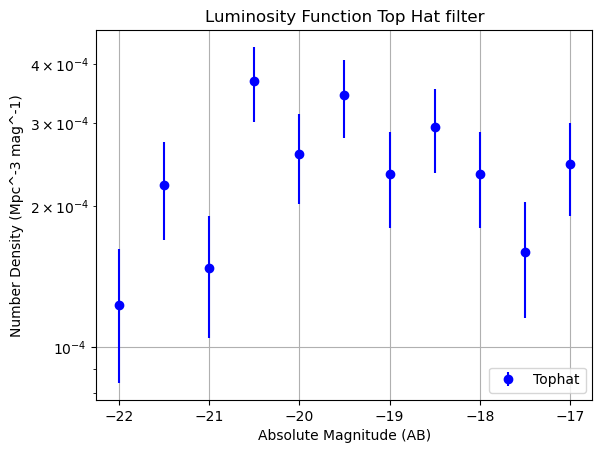

In [18]:

label_025 = 'z = ', redshift_074
label_th = 'Tophat'

# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', color='blue', label=label_th)

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower right')


plt.title('Luminosity Function Top Hat filter')
plt.grid(True)
plt.show()